# Molecular docking

In [1]:
from pymol import cmd
import py3Dmol

from vina import Vina

from openbabel import pybel

from rdkit import Chem
from rdkit.Chem import AllChem,rdFMCS, Draw

from meeko import MoleculePreparation
from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

import prolif as plf
from prolif.plotting.network import LigNetwork


import sys, os
sys.path.insert(1, 'utilities/')

from utils import fix_protein, getbox, generate_ledock_file, dok_to_sdf

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

In [2]:
#!wget http://mgltools.scripps.edu/downloads/previous-releases/downloads/tars/releases/nightly/1.0/REL/NewLinux/ADFRsuite_x86_64Linux_1.0.tar.gz
#!tar zxf ADFRsuite_x86_64Linux_1.0.tar.gz
#!mkdir ADFRsuite
#!cd ADFRsuite_x86_64Linux_1.0
#!/install.sh -d ../ADFRSuite -c 0
#!export PATH=/mnt/c/Users/angel/Desktop/Reverse_docking_vina/ADFRsuite/bin:$PATH

In [3]:
os.chdir('test/Molecular_Docking/')

## Fetching the system directly from PDB using pymol

In [4]:
cmd.fetch(code='1AZ8',type='pdb1')
cmd.select(name='Prot',selection='polymer.protein')
cmd.select(name='Lig',selection='organic')
cmd.save(filename='1AZ8_clean.pdb',format='pdb',selection='Prot')
cmd.save(filename='1AZ8_lig.mol2',format='mol2',selection='Lig')
cmd.delete('all')

 PyMOL not running, entering library mode (experimental)


## Protein sanitization

In [5]:
fix_protein(filename='1AZ8_clean.pdb',addHs_pH=7.4,try_renumberResidues=True,output='1AZ8_clean_H.pdb')

## Ligand sanitization

RDKit WARNING: [14:46:30] 1AZ8: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


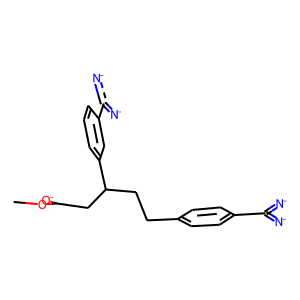

In [6]:
m=Chem.MolFromMol2File('1AZ8_lig.mol2',False)
Draw.MolToImage(m)

In [7]:
mol= [m for m in pybel.readfile(filename='1AZ8_lig.mol2',format='mol2')][0]
mol.addh()
out=pybel.Outputfile(filename='1AZ8_lig_H.mol2',format='mol2',overwrite=True)
out.write(mol)
out.close()

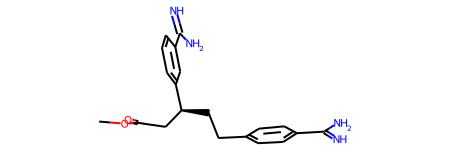

In [8]:
m=Chem.MolFromMol2File('1AZ8_lig_H.mol2')
m

## System visualization

In [9]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1AZ8_clean_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('1AZ8_lig_H.mol2','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Docking with Vina

### Protein preparation

In [10]:
!../../bin/prepare_receptor -v -r 1AZ8_clean_H.pdb -A hydrogens -o 1AZ8_clean_H.pdbqt

set verbose to  True
set receptor_filename to  1AZ8_clean_H.pdb
set repairs to  hydrogens
set outputfilename to  1AZ8_clean_H.pdbqt
read  1AZ8_clean_H.pdb
setting up RPO with mode= automatic and outputfilename=  1AZ8_clean_H.pdbqt
charges_to_add= gasteiger
delete_single_nonstd_residues= None
adding gasteiger charges to peptide


### Ligand preparation

#### Method 1: Meeko

In [11]:
'''
mol = obutils.load_molecule_from_file('1AZ8_lig_H.mol2')

preparator = MoleculePreparation(merge_hydrogens=True,hydrate=False)
preparator.prepare(mol)

preparator.write_pdbqt_file('1AZ8_lig_H.pdbqt')
'''

"\nmol = obutils.load_molecule_from_file('1AZ8_lig_H.mol2')\n\npreparator = MoleculePreparation(merge_hydrogens=True,hydrate=False)\npreparator.prepare(mol)\n\npreparator.write_pdbqt_file('1AZ8_lig_H.pdbqt')\n"

#### Method 2: Pybel

In [12]:
ligand = [m for m in pybel.readfile(filename='1AZ8_lig_H.mol2',format='mol2')][0]
out=pybel.Outputfile(filename='1AZ8_lig_H.pdbqt',format='pdbqt',overwrite=True)
ligand.addh()
out.write(ligand)
out.close()

#### Method 3: obabel

In [13]:
'''
!../../bin/obabel 1AZ8_lig_H.mol2 -O 1AZ8_lig_H.pdbqt -p 7.4
'''

'\n!../../bin/obabel 1AZ8_lig_H.mol2 -O 1AZ8_lig_H.pdbqt -p 7.4\n'

### Box definition

In [14]:
cmd.load(filename='1AZ8_clean_H.pdb',format='pdb',object='prot')
cmd.load(filename='1AZ8_lig_H.mol2',format='mol2',object='lig')

box_center, box_size= getbox(selection='lig',extending=5.0,software='vina')

cmd.delete('all')

print(box_center,'\n',box_size)

{'center_x': 31.859049797058105, 'center_y': 13.347449779510498, 'center_z': 17.06589984893799} 
 {'size_x': 24.56949806213379, 'size_y': 18.123299598693848, 'size_z': 17.374399185180664}


### Docking

#### Method 1: Vina python bindings 

In [15]:
v = Vina(sf_name='vina')

v.set_receptor('1AZ8_clean_H.pdbqt')

v.set_ligand_from_file('1AZ8_lig_H.pdbqt')

v.compute_vina_maps(center=[box_center['center_x'], box_center['center_y'], box_center['center_z']], 
                    box_size=[box_size['size_x'], box_size['size_y'], box_size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1AZ8_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=8, n_poses=5)
v.write_poses('1AZ8_lig_out_vina.pdbqt', n_poses=5, overwrite=True)

#### Metod 2: smina

In [16]:
print(box_center)
print (box_size)

{'center_x': 31.859049797058105, 'center_y': 13.347449779510498, 'center_z': 17.06589984893799}
{'size_x': 24.56949806213379, 'size_y': 18.123299598693848, 'size_z': 17.374399185180664}


In [17]:
'''
!../../bin/smina -r 1AZ8_clean_H.pdbqt -l 1AZ8_lig_H.pdbqt --center_x 31.859 --center_y 13.34 --center_z 17.065 --size_x 24.569 --size_y 18.12 --size_z 17.37 --exhaustiveness 8 --num_modes 5
'''

'\n!../../bin/smina -r 1AZ8_clean_H.pdbqt -l 1AZ8_lig_H.pdbqt --center_x 31.859 --center_y 13.34 --center_z 17.065 --size_x 24.569 --size_y 18.12 --size_z 17.37 --exhaustiveness 8 --num_modes 5\n'

### Docking results conversion from pdbqt to sdf

In [18]:
results = [m for m in pybel.readfile(filename='1AZ8_lig_out_vina.pdbqt',format='pdbqt')]
out=pybel.Outputfile(filename='1AZ8_lig_out_vina.sdf',format='sdf',overwrite=True)
for pose in results:
    pose.addh()
    out.write(pose)
out.close()

### Docking poses visualization

In [19]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1AZ8_clean_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('1AZ8_lig_H.mol2','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

results=Chem.SDMolSupplier('1AZ8_lig_out_vina.sdf')


p=Chem.MolToMolBlock(results[0])
print (results[0].GetProp('REMARK'))

view.addModel(p,'mol')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

view.zoomTo()
view.show()

 VINA RESULT:    -8.003      0.000      0.000
 INTER + INTRA:         -13.546
 INTER:                 -12.480
 INTRA:                  -1.066
 UNBOUND:                -1.332
  Name = 1AZ8
  10 active torsions:
  status: ('A' for Active; 'I' for Inactive)
    1  A    between atoms: C4_8  and  C10_16
    2  A    between atoms: O4_10  and  C8_14
    3  A    between atoms: O4_10  and  C22_26
    4  A    between atoms: C6_12  and  C20_25
    5  A    between atoms: C9_15  and  C10_16
    6  A    between atoms: C9_15  and  C11_17
    7  A    between atoms: C10_16  and  C14_20
    8  A    between atoms: C11_17  and  C12_18
    9  A    between atoms: C14_20  and  C22_26
   10  A    between atoms: C15_21  and  C16_22
                            x       y       z     vdW  Elec       q    Type
                         _______ _______ _______ _____ _____    ______ ____


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Molecular interacions

In [20]:
# load protein
prot = mda.Universe("1AZ8_clean_H.pdb",guess_bonds=True)
prot = plf.Molecule.from_mda(prot)
prot.n_residues

# load ligands
lig_suppl = list(plf.sdf_supplier('1AZ8_lig_out_vina.sdf'))
# generate fingerprint
fp = plf.Fingerprint()
fp.run_from_iterable(lig_suppl, prot)
results_df = fp.to_dataframe(return_atoms=True)
results_df

  0%|          | 0/5 [00:00<?, ?it/s]

ligand               UNL1                                            \
protein          ASN143.A                    ASP189.A                 
interaction    HBAcceptor       HBDonor       HBDonor   Hydrophobic   
0            (None, None)      (26, 10)      (11, 11)        (9, 9)   
1            (None, None)  (None, None)      (11, 11)        (9, 9)   
2                 (7, 11)      (10, 10)  (None, None)  (None, None)   
3            (None, None)  (None, None)      (25, 10)       (23, 9)   
4            (None, None)  (None, None)  (None, None)  (None, None)   

ligand                                                                       \
protein        CYS191.A    CYS220.A      GLN192.A    GLY216.A      GLY219.A   
interaction Hydrophobic Hydrophobic   Hydrophobic Hydrophobic       HBDonor   
0                (1, 2)      (5, 9)        (3, 2)      (5, 2)       (10, 6)   
1                (1, 2)      (5, 9)        (3, 2)      (5, 2)       (10, 6)   
2                (6, 9)      (5, 9)        (0, 6)     (18, 2)  (None, None)   
3               (15, 2)     (18, 9)       (14, 2)     (18, 2)       (26, 6)   
4                (1, 2)      (1, 9)  (None, None)      (1, 2)  (None, None)   

ligand                   ...                                            \
protein                  ...      SER147.A                    SER190.A   
interaction Hydrophobic  ...       HBDonor   Hydrophobic    HBAcceptor   
0               (15, 2)  ...       (25, 5)       (23, 2)       (8, 10)   
1               (27, 2)  ...  (None, None)  (None, None)       (8, 10)   
2               (20, 5)  ...  (None, None)  (None, None)      (21, 10)   
3               (19, 5)  ...  (None, None)  (None, None)      (21, 10)   
4                (2, 5)  ...  (None, None)  (None, None)  (None, None)   

ligand                                                                         \
protein                        SER195.A    SER214.A      TRP215.A               
interaction   Hydrophobic   Hydrophobic Hydrophobic    HBAcceptor Hydrophobic   
0                  (1, 4)  (None, None)      (2, 4)  (None, None)      (1, 2)   
1                  (1, 4)  (None, None)      (1, 4)  (None, None)      (1, 2)   
2                 (18, 4)  (None, None)     (17, 4)       (21, 1)     (15, 2)   
3                 (17, 4)       (31, 6)     (15, 4)  (None, None)      (1, 6)   
4            (None, None)  (None, None)      (5, 4)  (None, None)      (1, 2)   

ligand                                 
protein                      VAL213.A  
interaction    PiStacking Hydrophobic  
0            (None, None)      (1, 8)  
1            (None, None)      (1, 8)  
2            (None, None)     (17, 8)  
3            (None, None)     (15, 8)  
4                (15, 12)      (9, 8)  

[5 rows x 26 columns]

In [21]:
net = LigNetwork.from_ifp(results_df,lig_suppl[0],kind="frame", frame=0,rotation=270)
net.display()

## Docking with Ledock

### Box definition

In [22]:
cmd.load(filename='1AZ8_clean_H.pdb',format='pdb',object='prot')
cmd.load(filename='1AZ8_lig_H.mol2',format='mol2',object='lig')

X,Y,Z= getbox(selection='lig',extending=5.0,software='ledock')
cmd.delete('all')

print(X,'\n',Y,'\n',Z)

{'minX': 19.57430076599121, 'maxX': 44.143798828125} 
 {'minY': 4.285799980163574, 'maxY': 22.409099578857422} 
 {'minZ': 8.378700256347656, 'maxZ': 25.75309944152832}


### Ledock parameters (dock.in)

In [23]:
generate_ledock_file(receptor='1AZ8_clean_H.pdb',x=[X['minX'],X['maxX']],
                     y=[Y['minY'],Y['maxY']],
                     z=[Z['minZ'],Z['maxZ']],
                     n_poses=5, 
                     l_list='1AZ8_lig_H.mol2', l_list_outfile=
                     'ledock_ligand.list',
                     out='dock.in')

### Docking

In [24]:
!../../bin/ledock_linux_x86 dock.in

------------Warning: Missing Parameters for Residue: ILE @ H2--------------
------------Warning: Missing Parameters for Residue: ILE @ H3--------------


### Docking results conversion from dok to sdf

In [25]:
dok_to_sdf(dok_file='1AZ8_lig_H.dok',output='1AZ8_lig_out_ledock.sdf')

### Docking poses visualization

In [26]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1AZ8_clean_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('1AZ8_lig_H.mol2','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

results=Chem.SDMolSupplier('1AZ8_lig_out_ledock.sdf')


p=Chem.MolToMolBlock(results[0])
print (results[0].GetProp('REMARK'))

view.addModel(p,'mol')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

view.zoomTo()
view.show()

 Cluster   1 of Poses:  2 Score: -9.27 kcal/mol


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Molecular interactions

In [27]:
# load protein
prot = mda.Universe("1AZ8_clean_H.pdb",guess_bonds=True)
prot = plf.Molecule.from_mda(prot)
prot.n_residues

# load ligands
path = str('1AZ8_lig_out_ledock.sdf')
lig_suppl = list(plf.sdf_supplier(path))
# generate fingerprint
fp = plf.Fingerprint()
fp.run_from_iterable(lig_suppl, prot)
results_df = fp.to_dataframe(return_atoms=True)
results_df

  0%|          | 0/4 [00:00<?, ?it/s]

ligand               UNL1                                            \
protein          ASN143.A                    ASP189.A                 
interaction    HBAcceptor   Hydrophobic       HBDonor   Hydrophobic   
0            (None, None)       (21, 9)      (33, 10)       (24, 9)   
1            (None, None)  (None, None)  (None, None)       (24, 9)   
2                 (8, 11)  (None, None)  (None, None)       (21, 9)   
3            (None, None)       (21, 9)  (None, None)  (None, None)   

ligand                                                                       \
protein        CYS191.A    CYS220.A    GLN192.A      GLY148.A                 
interaction Hydrophobic Hydrophobic Hydrophobic       HBDonor   Hydrophobic   
0                (0, 2)      (7, 9)      (2, 2)  (None, None)       (21, 5)   
1                (0, 2)      (7, 9)      (2, 2)  (None, None)  (None, None)   
2               (12, 4)     (10, 9)      (4, 9)  (None, None)  (None, None)   
3                (0, 2)      (2, 9)     (10, 2)       (28, 6)       (21, 5)   

ligand                     ...                                            \
protein          GLY216.A  ...      SER147.A      SER190.A                 
interaction    HBAcceptor  ...   Hydrophobic    HBAcceptor       HBDonor   
0                  (6, 1)  ...       (21, 2)       (8, 10)  (None, None)   
1                  (6, 1)  ...       (21, 2)       (8, 10)  (None, None)   
2            (None, None)  ...  (None, None)       (3, 10)       (28, 5)   
3                  (6, 1)  ...       (21, 4)  (None, None)  (None, None)   

ligand                                                                         \
protein                      SER195.A      SER214.A                  TRP215.A   
interaction Hydrophobic   Hydrophobic       HBDonor   Hydrophobic Hydrophobic   
0                (0, 4)  (None, None)  (None, None)       (13, 4)      (0, 2)   
1                (0, 4)  (None, None)  (None, None)  (None, None)      (0, 2)   
2               (20, 4)  (None, None)  (None, None)       (18, 4)     (12, 2)   
3                (0, 4)       (24, 2)       (34, 5)       (13, 4)      (0, 2)   

ligand                                 
protein        VAL213.A      VAL227.A  
interaction Hydrophobic    HBAcceptor  
0                (0, 8)  (None, None)  
1                (0, 8)  (None, None)  
2               (18, 8)        (3, 1)  
3               (24, 8)  (None, None)  

[4 rows x 29 columns]

In [28]:
net = LigNetwork.from_ifp(results_df,lig_suppl[0],kind="frame", frame=0,rotation=270)
net.display()